In [ ]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
%matplotlib inline

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)``
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)    

REPLICAS:  1


In [ ]:
imagePatches = glob('/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x951_y701_class0.png
/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1351_y1151_class0.png
/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1551_y601_class0.png
/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1901_y1101_class0.png
/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x451_y651_class0.png
/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x551_y751_class0.png
/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1501_y601_class0.png
/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y701_class0.png
/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1251_y601_class0.png
/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1351_class0.png


In [ ]:
# Two arrays holding images by class type

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [ ]:
len(class1)

1965

In [ ]:
sampled_class0 = random.sample(class0, 1965)
sampled_class1 = random.sample(class1, 1965)
len(sampled_class0)

1965

In [ ]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (70, 70), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [ ]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [ ]:
class0_array[1]

[array([[[167, 125, 224],
         [159, 116, 221],
         [154, 110, 221],
         ...,
         [175, 138, 205],
         [181, 144, 207],
         [180, 140, 200]],
 
        [[162, 120, 221],
         [165, 125, 222],
         [165, 124, 222],
         ...,
         [164, 119, 161],
         [175, 134, 178],
         [190, 157, 209]],
 
        [[156, 113, 218],
         [167, 128, 222],
         [172, 133, 223],
         ...,
         [167, 122, 150],
         [176, 135, 171],
         [192, 159, 212]],
 
        ...,
 
        [[166, 125, 222],
         [168, 124, 219],
         [173, 129, 217],
         ...,
         [174, 132, 225],
         [170, 127, 224],
         [168, 124, 222]],
 
        [[168, 129, 221],
         [168, 127, 222],
         [170, 128, 223],
         ...,
         [174, 133, 222],
         [172, 130, 222],
         [169, 126, 221]],
 
        [[169, 130, 218],
         [167, 128, 222],
         [166, 125, 225],
         ...,
         [173, 130, 217],
  

In [ ]:
test = cv2.imread('/content/drive/MyDrive/Breast_cancer/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png' ,cv2.IMREAD_COLOR)
# test.shape()

In [ ]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(41)
random.shuffle(combined_data)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [ ]:
# print(X[11].reshape(-1, 50, 50, 3))
# reshape X data
X = np.array(X).reshape(-1, 70, 70, 3)

In [ ]:
X.shape

(3930, 70, 70, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2751, 70, 70, 3) (1179, 70, 70, 3) (2751, 2) (1179, 2)


In [ ]:
from tensorflow.keras.applications import DenseNet201

In [ ]:
base_model = tf.keras.applications.DenseNet201(input_shape=(70,70,3),include_top=False,weights="imagenet")

74836368/74836368 [==============================] - 1s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers[:-5]:
    layer.trainable=False

In [ ]:
# Building Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D,RepeatVector

model=Sequential()
model.add(base_model)
model.add(Dropout(0.4))

model.add(Flatten())
model.add(RepeatVector(2))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

In [ ]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 2, 1920)        18321984  
                                                                 
 dropout (Dropout)           (None, 2, 2, 1920)        0         
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 repeat_vector (RepeatVector  (None, 2, 7680)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 15360)             0         
                                                                 
 dense (Dense)               (None, 2)                 30722     
                                                        

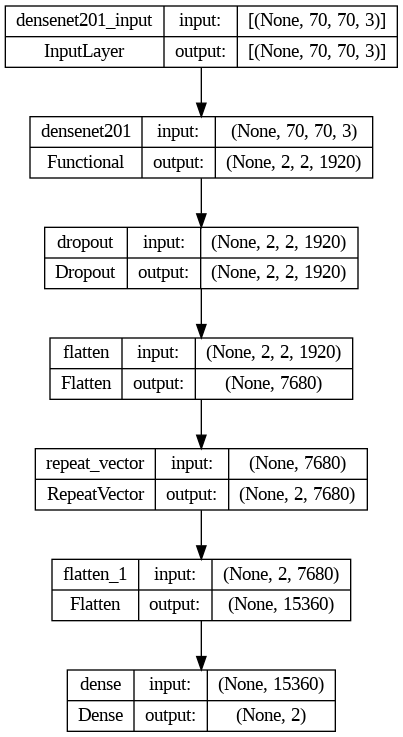

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.75, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=5)

In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=METRICS)

In [ ]:
%time
history=model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 12,callbacks=[lrd,mcp,es])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
Epoch 1/12
86/86 [==============================] - 156s 1s/step - loss: 0.3832 - accuracy: 0.8688 - precision: 0.8688 - recall: 0.8688 - auc: 0.9348 - f1_score: 0.8688 - val_loss: 0.5814 - val_accuracy: 0.8541 - val_precision: 0.8541 - val_recall: 0.8541 - val_auc: 0.9017 - val_f1_score: 0.8541 - lr: 0.0010
Epoch 2/12
86/86 [==============================] - 100s 1s/step - loss: 0.3122 - accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953 - auc: 0.9466 - f1_score: 0.8953 - val_loss: 0.4436 - val_accuracy: 0.8838 - val_precision: 0.8838 - val_recall: 0.8838 - val_auc: 0.9220 - val_f1_score: 0.8837 - lr: 0.0010
Epoch 3/12
86/86 [==============================] - 110s 1s/step - loss: 0.2545 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9605 - f1_score: 0.9037 - val_loss: 0.3260 - val_accuracy: 0.8914 - val_precision: 0.8914 - val_recall: 0.8914 - val_auc: 0.9453 - val_f1_score: 0.8913 - lr: 0.0010
Epoch 

In [ ]:
model.save('/content/drive/MyDrive/Breast_Cancer_models/densemodel.h5')

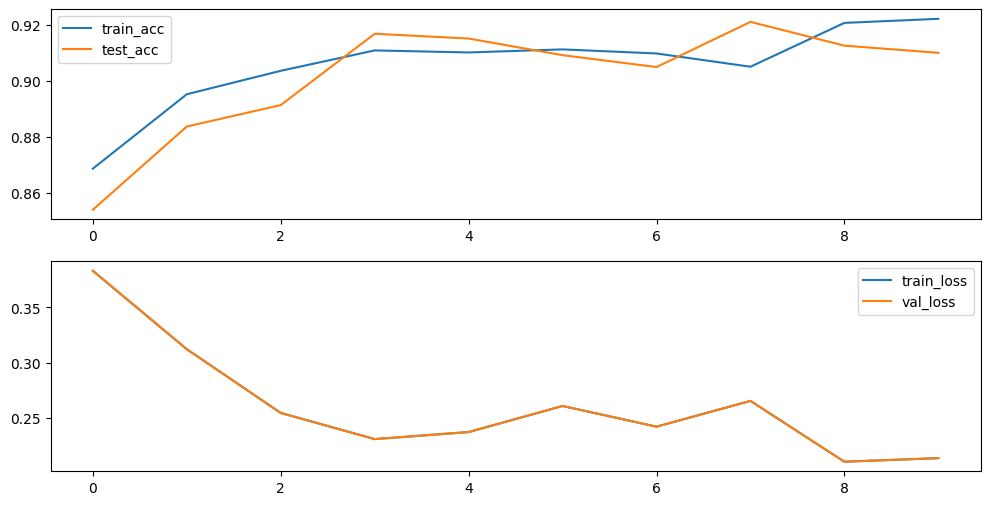

In [ ]:
#plot the accuracy graph
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label = "train_loss")
plt.plot(history.history['loss'], label = "val_loss")
plt.legend()

37/37 [==============================] - 32s 725ms/step


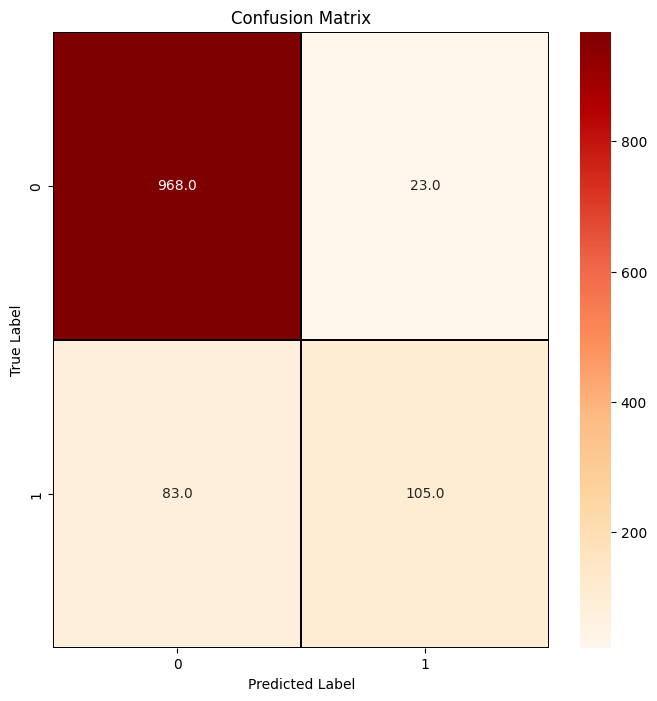

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       991
           1       0.82      0.56      0.66       188

    accuracy                           0.91      1179
   macro avg       0.87      0.77      0.81      1179
weighted avg       0.90      0.91      0.90      1179



In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

In [ ]:
data_dir = '/content/drive/MyDrive/Breast_cancer/'

In [ ]:
IDS=[]
for ids in os.listdir(data_dir):
    if ids != 'IDC_regular_ps50_idx5':
        IDS+=[ids]
print(IDS)
print(len(IDS))

['10253', '10254', '10255', '10256', '10257', '10258', '10259', '10260', '10261', '10262', '10264', '10268', '10269', '10272', '10273', '10274', '10275', '10276', '10277', '10278', '10279', '10282', '10285', '10286', '10288', '10290', '10291', '10292', '10293', '10295', '10299', '10300', '10301', '10302', '10303', '10304', '10305', '10306', '10307', '10308', '12241', '12242', '12626', '12748', '12749', '12750', '12751', '12752', '12810', '12811', '12817', '12818', '12819', '12820', '12821', '12822', '12823', '12824', '12826', '12867', '12868', '12869', '12870', '12871', '12872', '12873', '12875', '12876', '12877', '12878', '12879', '12880', '12881', '12882', '12883', '12884', '12886', '12890', '12891', '12892', '12893', '12894', '12895', '12896', '12897', '12898', '12900', '12901', '12905', '12906', '12907', '12908', '12909', '12910', '12911', '12929', '12930', '12931', '12932', '12933', '12934', '12935', '12947', '12948', '12949', '12951', '12954', '12955', '13018', '13019', '13020', 

In [ ]:
Name=['non-IDC','IDC']
Fname=['0','1']

In [ ]:
N=[]
for i in range(len(Name)):
    N+=[i]
    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]

In [ ]:
image=load_img("/content/drive/MyDrive/Breast_cancer/10254/1/10254_idx5_x1651_y1001_class0.png",target_size=(70,70))
image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [ ]:
prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
print("Prediction is {}.".format(move_name))

1/1 [==============================] - 0s 85ms/step
Prediction is non-IDC.


The input image dosen't contain cnacer and is predicted as non cancer.

In [ ]:
pred2=model.predict(X_test)


PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]

37/37 [==============================] - 28s 735ms/step
